# Speech Emotion Detection Classifier

## 1. Import all the necessary libraries

In [1]:
# Core libraries
import os
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

# Audio processing libraries
import librosa
import librosa.display
import soundfile as sf 

# Visualization libraries
import IPython.display as ipd
from IPython.display import Audio

# Machine learning libraries
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# Deep Learning libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Flatten, Conv1D, MaxPooling1D
from tensorflow.keras.utils import to_categorical
import tensorflow as tf 


import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## 2. Data Loading

In [2]:
Ravdess = "ravdess/audio_speech_actors_01-24/"
Crema = "crema/AudioWAV/"
Tess = "tess/TESS Toronto emotional speech set data/"
Savee = "savee/ALL/"

### 2.1 Data Exploration

✅ 1. Exploring Datasets: Extracts .wav files from directories

✅ 2. Mapping Emotions: Converts filenames into emotion labels for each dataset

#### 2.1.1 Function to explore datasets 

In [3]:
def explore_dataset(dataset_path):
    file_list = [f for f in os.listdir(dataset_path) if f.endswith('.wav')]
    print(f"Sample files in {dataset_path}:")
    print(file_list[:5])
    return file_list

ravdess_files = explore_dataset(Ravdess)
crema_files = explore_dataset(Crema)
tess_files = explore_dataset(Tess)
savee_files = explore_dataset(Savee)

Sample files in ravdess/audio_speech_actors_01-24/:
[]
Sample files in crema/AudioWAV/:
['1001_DFA_ANG_XX.wav', '1001_DFA_DIS_XX.wav', '1001_DFA_FEA_XX.wav', '1001_DFA_HAP_XX.wav', '1001_DFA_NEU_XX.wav']
Sample files in tess/TESS Toronto emotional speech set data/:
[]
Sample files in savee/ALL/:
['DC_a01.wav', 'DC_a02.wav', 'DC_a03.wav', 'DC_a04.wav', 'DC_a05.wav']


### 2.1.2 Map Integers to Emotions


In [4]:
def map_emotion_ravdess(filename):
    """Extracts emotion from RAVDESS filename."""
    emotions = {
        "01": "neutral", "02": "calm", "03": "happy", "04": "sad",
        "05": "angry", "06": "fearful", "07": "disgust", "08": "surprised"
    }
    emotion_code = filename.split("-")[2]  # Extracts emotion code
    return emotions.get(emotion_code, "unknown")

In [5]:
def map_emotion_crema(filename):
    """Extracts emotion from CREMA-D filename."""
    emotions = {
        "NEU": "neutral", "HAP": "happy", "SAD": "sad", "ANG": "angry",
        "FEA": "fearful", "DIS": "disgust"
    }
    return emotions.get(filename.split('_')[2], "unknown")

In [6]:
def map_emotion_tess(filename):
    """Extracts emotion from TESS filename."""
    emotions = {
        "neutral": "neutral", "happy": "happy", "sad": "sad", "angry": "angry",
        "fear": "fearful", "disgust": "disgust", "ps": "surprised"
    }
    emotion_key = filename.split('_')[-1].split('.')[0]  # Extract last part before .wav
    return emotions.get(emotion_key, "unknown")

In [7]:
def map_emotion_savee(filename):
    """Extracts emotion from SAVEE filename."""
    emotions = {
        "a": "angry", "d": "disgust", "f": "fearful", "h": "happy",
        "n": "neutral", "sa": "sad", "su": "surprised"
    }
    for key in emotions:
        if key in filename[:2]:  # Check prefix
            return emotions[key]
    return "unknown"

### 3. Create one DataFrame 

In [8]:
# Function to create DataFrame from dataset
def create_dataframe(file_list, label_function):
    data = []
    for file_path in file_list:
        filename = os.path.basename(file_path)
        label = label_function(filename)
        data.append({'file_path': file_path, 'label': label})
    return pd.DataFrame(data)

# Create DataFrames with updated file lists
ravdess_df = create_dataframe(ravdess_files, map_emotion_ravdess)
crema_df = create_dataframe(crema_files, map_emotion_crema)
tess_df = create_dataframe(tess_files, map_emotion_tess)
savee_df = create_dataframe(savee_files, map_emotion_savee)

#### Emotion Mapping Output

In [10]:
print("\nRAVDESS DataFrame Columns:")
print(ravdess_df.columns)

print("\nCREMA-D DataFrame Columns:")
print(crema_df.columns)

print("\nTESS DataFrame Columns:")
print(tess_df.columns)

print("\nSAVEE DataFrame Columns:")
print(savee_df.columns)



RAVDESS DataFrame Columns:
RangeIndex(start=0, stop=0, step=1)

CREMA-D DataFrame Columns:
Index(['file_path', 'label'], dtype='object')

TESS DataFrame Columns:
RangeIndex(start=0, stop=0, step=1)

SAVEE DataFrame Columns:
Index(['file_path', 'label'], dtype='object')


In [11]:
def explore_dataset_recursive(dataset_path):
    file_list = []
    for root, _, files in os.walk(dataset_path):
        for file in files:
            if file.endswith('.wav'):
                file_list.append(os.path.join(root, file))
    print(f"Sample files in {dataset_path}: {file_list[:5]}")
    return file_list

ravdess_files = explore_dataset_recursive(Ravdess)
tess_files = explore_dataset_recursive(Tess)


Sample files in ravdess/audio_speech_actors_01-24/: ['ravdess/audio_speech_actors_01-24/Actor_01\\03-01-01-01-01-01-01.wav', 'ravdess/audio_speech_actors_01-24/Actor_01\\03-01-01-01-01-02-01.wav', 'ravdess/audio_speech_actors_01-24/Actor_01\\03-01-01-01-02-01-01.wav', 'ravdess/audio_speech_actors_01-24/Actor_01\\03-01-01-01-02-02-01.wav', 'ravdess/audio_speech_actors_01-24/Actor_01\\03-01-02-01-01-01-01.wav']
Sample files in tess/TESS Toronto emotional speech set data/: ['tess/TESS Toronto emotional speech set data/OAF_angry\\OAF_back_angry.wav', 'tess/TESS Toronto emotional speech set data/OAF_angry\\OAF_bar_angry.wav', 'tess/TESS Toronto emotional speech set data/OAF_angry\\OAF_base_angry.wav', 'tess/TESS Toronto emotional speech set data/OAF_angry\\OAF_bath_angry.wav', 'tess/TESS Toronto emotional speech set data/OAF_angry\\OAF_bean_angry.wav']


In [15]:
import os
import pandas as pd

# Emotion mapping for RAVDESS
RAVDESS_EMOTIONS = {
    "01": "neutral", "02": "calm", "03": "happy", "04": "sad",
    "05": "angry", "06": "fearful", "07": "disgust", "08": "surprised"
}

# Function to extract emotions from filenames
def extract_label(filename, dataset):
    if dataset == "RAVDESS":
        parts = filename.split("-")  # RAVDESS format: "02-01-06-01-02-01-12.wav"
        if len(parts) > 2:
            return RAVDESS_EMOTIONS.get(parts[2], "unknown")  # Emotion code at index 2

    elif dataset == "CREMA":
        return filename.split("_")[2]  # Example: "1001_DFA_ANG_XX.wav" -> 'ANG'

    elif dataset == "TESS":
        if "angry" in filename:
            return "angry"
        elif "happy" in filename:
            return "happy"
        elif "sad" in filename:
            return "sad"
        elif "fear" in filename:
            return "fearful"
        elif "neutral" in filename:
            return "neutral"
        elif "disgust" in filename:
            return "disgust"
        elif "ps" in filename:
            return "surprised"

    elif dataset == "SAVEE":
        emotions = {'a': "angry", 'd': "disgust", 'f': "fearful", 'h': "happy", 
                    'n': "neutral", 'sa': "sad", 'su': "surprised"}
        emotion_code = filename.split("_")[1][:2]  # Extract emotion part from 'DC_a01.wav'
        return emotions.get(emotion_code, "unknown")

    return "unknown"


In [16]:
# Create DataFrames with extracted labels
ravdess_df = pd.DataFrame({'file_path': ravdess_files, 'label': [extract_label(f, "RAVDESS") for f in ravdess_files]})
crema_df = pd.DataFrame({'file_path': crema_files, 'label': [extract_label(f, "CREMA") for f in crema_files]})
tess_df = pd.DataFrame({'file_path': tess_files, 'label': [extract_label(f, "TESS") for f in tess_files]})
savee_df = pd.DataFrame({'file_path': savee_files, 'label': [extract_label(f, "SAVEE") for f in savee_files]})


In [17]:
print("\nRAVDESS Emotion Mapping:")
print(ravdess_df['label'].value_counts())

print("\nCREMA-D Emotion Mapping:")
print(crema_df['label'].value_counts())

print("\nTESS Emotion Mapping:")
print(tess_df['label'].value_counts())

print("\nSAVEE Emotion Mapping:")
print(savee_df['label'].value_counts())


RAVDESS Emotion Mapping:
label
neutral    1440
Name: count, dtype: int64

CREMA-D Emotion Mapping:
label
ANG    729
DIS    729
FEA    729
HAP    729
SAD    727
NEU    622
Name: count, dtype: int64

TESS Emotion Mapping:
label
angry        400
disgust      400
fearful      400
happy        400
neutral      400
surprised    400
sad          400
Name: count, dtype: int64

SAVEE Emotion Mapping:
label
unknown      360
sad           60
surprised     60
Name: count, dtype: int64


#### Combine all Datasets and save combined dataset

In [18]:
all_data = pd.concat([ravdess_df, crema_df, tess_df, savee_df])
all_data.reset_index(drop=True, inplace=True)

all_data.to_csv("all_speech_emotions.csv", index=False)
print("\nCombined dataset saved as 'all_speech_emotions.csv'. ")


Combined dataset saved as 'all_speech_emotions.csv'. 


#### Overall emotion distribution

In [19]:
print("\nOverall Emotion Distribution:")
print(all_data['label'].value_counts())


Overall Emotion Distribution:
label
neutral      1840
ANG           729
DIS           729
FEA           729
HAP           729
SAD           727
NEU           622
surprised     460
sad           460
angry         400
disgust       400
fearful       400
happy         400
unknown       360
Name: count, dtype: int64


## 4. 📊 Visualizing Data Distribution for All Emotion Datasets

## 4.1 Basic Visualizations
The following code explores, maps emotions, and visualizes the distribution of emotions from all four datasets:

We will use Matplotlib and Seaborn to plot: 

✅ Bar Chart - Emotion counts

✅ Pie Chart - Emotion percentage

✅ Histogram - Distribution of emotion occurrences

In [24]:
# Count occurrences of each emotion
emotion_counts = all_data['label'].value_counts()

# 🎨 Set seaborn theme
sns.set_theme(style="darkgrid")

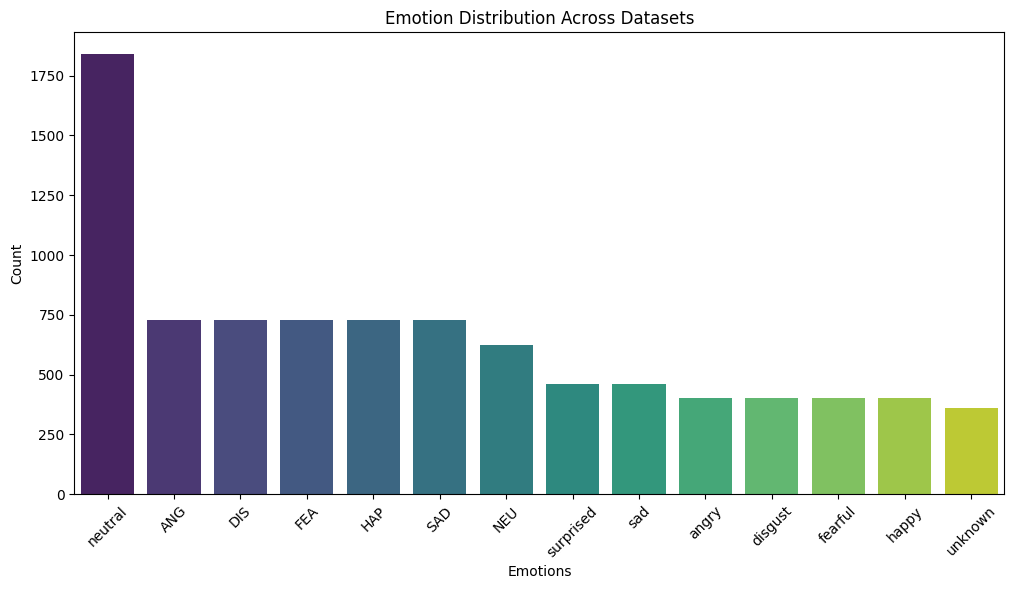

In [20]:
plt.figure(figsize=(12, 6))
sns.countplot(x=all_data['label'], order=all_data['label'].value_counts().index, palette="viridis")
plt.xticks(rotation=45)
plt.xlabel("Emotions")
plt.ylabel("Count")
plt.title("Emotion Distribution Across Datasets")
plt.show()

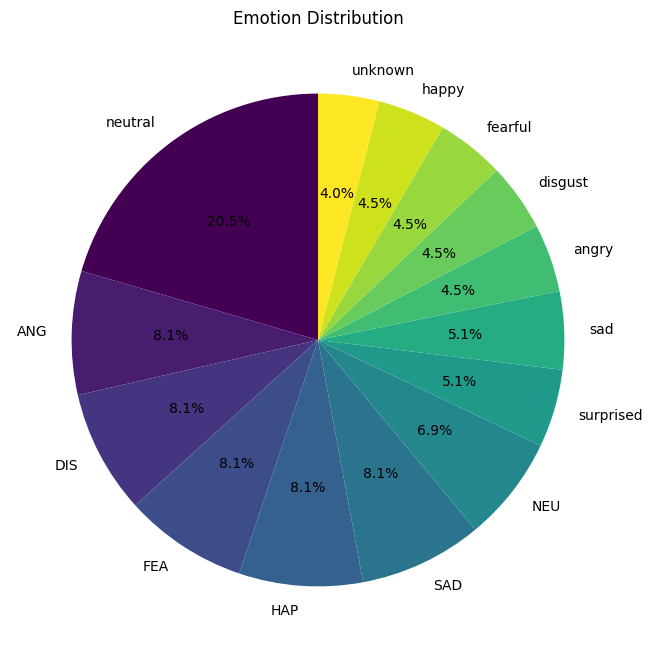

In [21]:
plt.figure(figsize=(8, 8))
all_data['label'].value_counts().plot.pie(autopct='%1.1f%%', cmap='viridis', startangle=90)
plt.title("Emotion Distribution")
plt.ylabel("")
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_14408\433381024.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(all_data['label'], bins=len(emotion_counts), kde=False, palette="viridis")


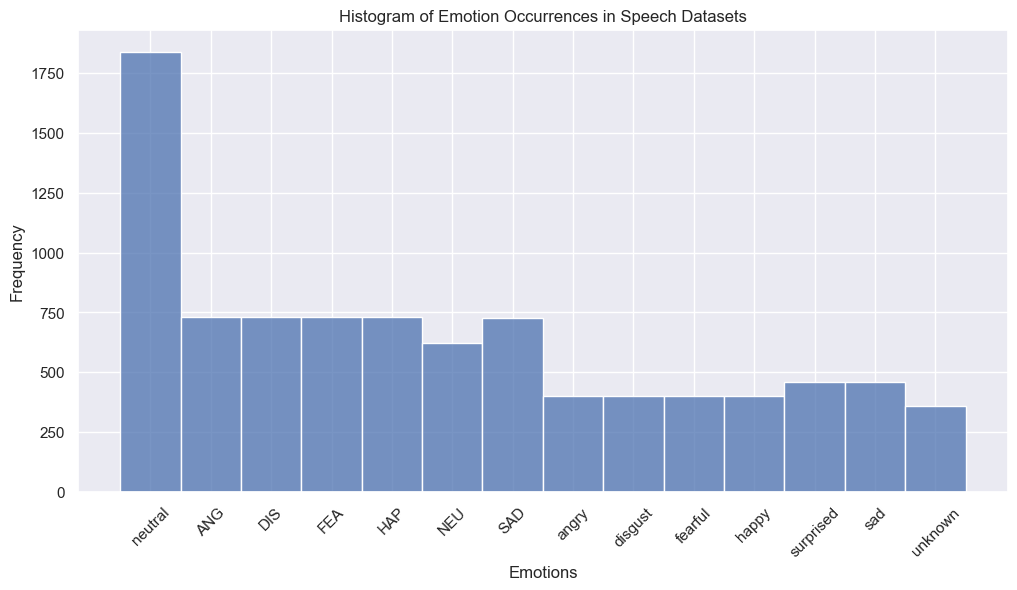

In [27]:
plt.figure(figsize=(12, 6))
sns.histplot(all_data['label'], bins=len(emotion_counts), kde=False, palette="viridis")
plt.xlabel("Emotions")
plt.ylabel("Frequency")
plt.title("Histogram of Emotion Occurrences in Speech Datasets")
plt.xticks(rotation=45)
plt.show()

#### 2.1.2.1 Ravdess Dataset

Update explore_dataset to Recursively List Files: 

We modify the function to list all files within the subfolders (e.g., for Actor_01 to Actor_24).

In [4]:
def explore_dataset(dataset_path):
    file_list = []
    # Loop through all subdirectories (Actor_01, Actor_02, etc.)
    for actor_folder in os.listdir(dataset_path):
        actor_folder_path = os.path.join(dataset_path, actor_folder)
        if os.path.isdir(actor_folder_path):  # Ensure it's a folder
            # Add all .wav files from each actor's folder to the list
            files = [f for f in os.listdir(actor_folder_path) if f.endswith('.wav')]
            file_list.extend(files)  # Add files to the overall list
    print(f"Sample files in {dataset_path}:")
    print(file_list[:5])  # Print the first 5 files
    return file_list


Since the emotion code is embedded in the filename but structured differently (e.g., something like Actor_01-03-01-01-01-01.wav), we extract the emotion code accordingly. 

If the emotion code is at a specific position in the filename, modify the extraction logic.

In [5]:
def map_emotion_ravdess(filename):
    parts = filename.split('-')
    emotion_code = int(parts[2])
    emotion_mapping = {
        1: 'neutral', 2: 'calm', 3: 'happy', 4: 'sad',
        5: 'angry', 6: 'fearful', 7: 'disgust', 8: 'surprised'
    }
    return emotion_mapping.get(emotion_code, "unknown")

ravdess_files = explore_dataset(Ravdess)
ravdess_mapped_emotions = [map_emotion_ravdess(f) for f in ravdess_files[:30]]
for emotion in ravdess_mapped_emotions:
    print(emotion)

Sample files in ravdess/audio_speech_actors_01-24/:
['03-01-01-01-01-01-01.wav', '03-01-01-01-01-02-01.wav', '03-01-01-01-02-01-01.wav', '03-01-01-01-02-02-01.wav', '03-01-02-01-01-01-01.wav']
neutral
neutral
neutral
neutral
calm
calm
calm
calm
calm
calm
calm
calm
happy
happy
happy
happy
happy
happy
happy
happy
sad
sad
sad
sad
sad
sad
sad
sad
angry
angry


#### 2.1.2.2 Crema Dataset

In [6]:
def explore_dataset(directory_path):
    print(f"Exploring directory: {directory_path}")
    files = os.listdir(directory_path)
    print(f"Files found: {files}")
    return files

crema_files = explore_dataset(Crema)


Exploring directory: crema/AudioWAV/
Files found: ['1001_DFA_ANG_XX.wav', '1001_DFA_DIS_XX.wav', '1001_DFA_FEA_XX.wav', '1001_DFA_HAP_XX.wav', '1001_DFA_NEU_XX.wav', '1001_DFA_SAD_XX.wav', '1001_IEO_ANG_HI.wav', '1001_IEO_ANG_LO.wav', '1001_IEO_ANG_MD.wav', '1001_IEO_DIS_HI.wav', '1001_IEO_DIS_LO.wav', '1001_IEO_DIS_MD.wav', '1001_IEO_FEA_HI.wav', '1001_IEO_FEA_LO.wav', '1001_IEO_FEA_MD.wav', '1001_IEO_HAP_HI.wav', '1001_IEO_HAP_LO.wav', '1001_IEO_HAP_MD.wav', '1001_IEO_NEU_XX.wav', '1001_IEO_SAD_HI.wav', '1001_IEO_SAD_LO.wav', '1001_IEO_SAD_MD.wav', '1001_IOM_ANG_XX.wav', '1001_IOM_DIS_XX.wav', '1001_IOM_FEA_XX.wav', '1001_IOM_HAP_XX.wav', '1001_IOM_NEU_XX.wav', '1001_IOM_SAD_XX.wav', '1001_ITH_ANG_XX.wav', '1001_ITH_DIS_XX.wav', '1001_ITH_FEA_XX.wav', '1001_ITH_HAP_XX.wav', '1001_ITH_NEU_XX.wav', '1001_ITH_SAD_XX.wav', '1001_ITS_ANG_XX.wav', '1001_ITS_DIS_XX.wav', '1001_ITS_FEA_XX.wav', '1001_ITS_HAP_XX.wav', '1001_ITS_NEU_XX.wav', '1001_ITS_SAD_XX.wav', '1001_IWL_ANG_XX.wav', '1001_

In [7]:
def map_emotion_crema(filename):
    parts = filename.split('_')
    emotion_code = parts[2]
    emotion_mapping = {
        'NEU': 'neutral', 'HAP': 'happy', 'SAD': 'sad', 
        'ANG': 'angry', 'DIS': 'disgust', 'FEA': 'fearful', 
        'SUR': 'surprised'
    }
    return emotion_mapping.get(emotion_code, "unknown")

crema_files = explore_dataset(Crema)
crema_mapped_emotions = [map_emotion_crema(f) for f in crema_files[:30]]
for emotion in crema_mapped_emotions:
    print(emotion)

Exploring directory: crema/AudioWAV/
Files found: ['1001_DFA_ANG_XX.wav', '1001_DFA_DIS_XX.wav', '1001_DFA_FEA_XX.wav', '1001_DFA_HAP_XX.wav', '1001_DFA_NEU_XX.wav', '1001_DFA_SAD_XX.wav', '1001_IEO_ANG_HI.wav', '1001_IEO_ANG_LO.wav', '1001_IEO_ANG_MD.wav', '1001_IEO_DIS_HI.wav', '1001_IEO_DIS_LO.wav', '1001_IEO_DIS_MD.wav', '1001_IEO_FEA_HI.wav', '1001_IEO_FEA_LO.wav', '1001_IEO_FEA_MD.wav', '1001_IEO_HAP_HI.wav', '1001_IEO_HAP_LO.wav', '1001_IEO_HAP_MD.wav', '1001_IEO_NEU_XX.wav', '1001_IEO_SAD_HI.wav', '1001_IEO_SAD_LO.wav', '1001_IEO_SAD_MD.wav', '1001_IOM_ANG_XX.wav', '1001_IOM_DIS_XX.wav', '1001_IOM_FEA_XX.wav', '1001_IOM_HAP_XX.wav', '1001_IOM_NEU_XX.wav', '1001_IOM_SAD_XX.wav', '1001_ITH_ANG_XX.wav', '1001_ITH_DIS_XX.wav', '1001_ITH_FEA_XX.wav', '1001_ITH_HAP_XX.wav', '1001_ITH_NEU_XX.wav', '1001_ITH_SAD_XX.wav', '1001_ITS_ANG_XX.wav', '1001_ITS_DIS_XX.wav', '1001_ITS_FEA_XX.wav', '1001_ITS_HAP_XX.wav', '1001_ITS_NEU_XX.wav', '1001_ITS_SAD_XX.wav', '1001_IWL_ANG_XX.wav', '1001_

#### 2.1.2.3 Tess Dataset

In [8]:
import os

def explore_dataset(directory):
    file_list = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".wav"):
                file_list.append(os.path.join(root, file))
                
    return file_list
tess_path = "tess/TESS Toronto emotional speech set data/"

print(tess_files[:10])
                

[]


In [9]:
def map_emotion_tess(filename):
    emotion_keywords = {
        "neutral": "neutral", "happy": "happy", "sad": "sad",
        "angry": "angry", "fear": "fearful", "disgust": "disgust",
        "ps": "surprised"
    }
    for key, emotion in emotion_keywords.items():
        if key in filename.lower():
            return emotion
    return "unknown"

tess_files = explore_dataset(tess_path)
tess_mapped_emotions = [map_emotion_tess(f) for f in tess_files[:30]]

print("\nTESS Emotions:")
print("\n".join(tess_mapped_emotions))


TESS Emotions:
angry
angry
angry
angry
angry
angry
angry
angry
angry
angry
angry
angry
angry
angry
angry
angry
angry
angry
angry
angry
angry
angry
angry
angry
angry
angry
angry
angry
angry
angry


#### 2.1.2.4 Savee Dataset

First we get a Function to explore the dataset and list all audio files


In [10]:
def explore_dataset(directory):
    file_list = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".wav"):
                file_list.append(file)
    return file_list 

savee_path = "savee/ALL/"
savee_files = explore_dataset(savee_path)

print(savee_files[:10])           

['DC_a01.wav', 'DC_a02.wav', 'DC_a03.wav', 'DC_a04.wav', 'DC_a05.wav', 'DC_a06.wav', 'DC_a07.wav', 'DC_a08.wav', 'DC_a09.wav', 'DC_a10.wav']


Let's map emotions

In [11]:
def map_emotion_savee(filename):
    emotion_mapping = {
        "n": "neutral", "h": "happy", "sa": "sad", "a": "angry",
        "f": "fearful", "d": "disgust", "su": "surprised"
    }
    # Extracting the first characters of the filename for emotion mapping
    code = filename[3:5] if filename[3:5] in emotion_mapping else filename[3]
    return emotion_mapping.get(code, "unknown")

savee_files = explore_dataset(savee_path)

savee_mapped_emotions = [(f, map_emotion_savee(f)) for f in savee_files]

print("SAVEE Dataset - Mapped Emotions:")
for file, emotion in savee_mapped_emotions[:30]:
    print(f"{file} → {emotion}")

SAVEE Dataset - Mapped Emotions:
DC_a01.wav → angry
DC_a02.wav → angry
DC_a03.wav → angry
DC_a04.wav → angry
DC_a05.wav → angry
DC_a06.wav → angry
DC_a07.wav → angry
DC_a08.wav → angry
DC_a09.wav → angry
DC_a10.wav → angry
DC_a11.wav → angry
DC_a12.wav → angry
DC_a13.wav → angry
DC_a14.wav → angry
DC_a15.wav → angry
DC_d01.wav → disgust
DC_d02.wav → disgust
DC_d03.wav → disgust
DC_d04.wav → disgust
DC_d05.wav → disgust
DC_d06.wav → disgust
DC_d07.wav → disgust
DC_d08.wav → disgust
DC_d09.wav → disgust
DC_d10.wav → disgust
DC_d11.wav → disgust
DC_d12.wav → disgust
DC_d13.wav → disgust
DC_d14.wav → disgust
DC_d15.wav → disgust


## 2.2 📊 Visualizing Data Distribution for All Emotion Datasets

## 2.2.1 Basic Visualizations
The following code explores, maps emotions, and visualizes the distribution of emotions from all four datasets:

We will use Matplotlib and Seaborn to plot: 

✅ Bar Chart - Emotion counts

✅ Pie Chart - Emotion percentage

✅ Histogram - Distribution of emotion occurrences

#### 

#### 2.2.1.1 combine all emotions into a single list

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [13]:
all_emotions = ravdess_files + crema_files + savee_files + tess_files

# count occurrences of each emotion
emotion_counts = Counter(all_emotions)

In [14]:
import pandas as pd

# Convert list to Pandas Series
all_emotions_series = pd.Series(all_emotions)

# Print value counts
print(all_emotions_series.value_counts())


angry                       38
happy                       13
sad                         13
calm                         8
neutral                      7
                            ..
(JE_f05.wav, fearful)        1
(JE_f04.wav, fearful)        1
(JE_f03.wav, fearful)        1
(JE_f02.wav, fearful)        1
(KL_su15.wav, surprised)     1
Name: count, Length: 487, dtype: int64


In [15]:
print(all_emotions[:10])  # Print first 10 elements


['neutral', 'neutral', 'neutral', 'neutral', 'calm', 'calm', 'calm', 'calm', 'calm', 'calm']


#### 2.2.1.2 Bar Chart - Emotion Counts

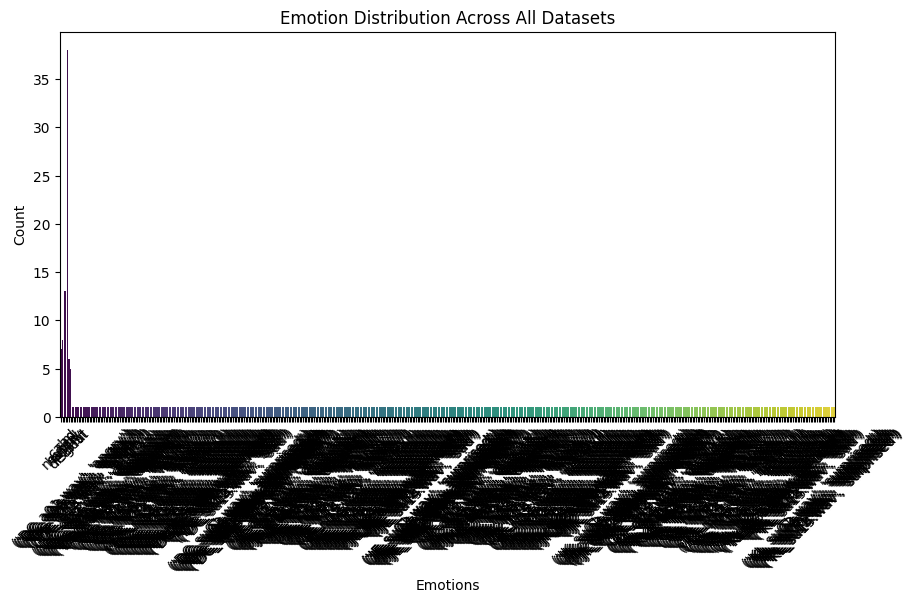

In [16]:
plt.figure(figsize=(10, 5))
sns.barplot(x=list(emotion_counts.keys()), y=list(emotion_counts.values()), palette="viridis")
plt.xlabel("Emotions")
plt.ylabel("Count")
plt.title("Emotion Distribution Across All Datasets")
plt.xticks(rotation=45)
plt.show()

#### 2.2.1.3 Pie Chart - Emotion Percentage

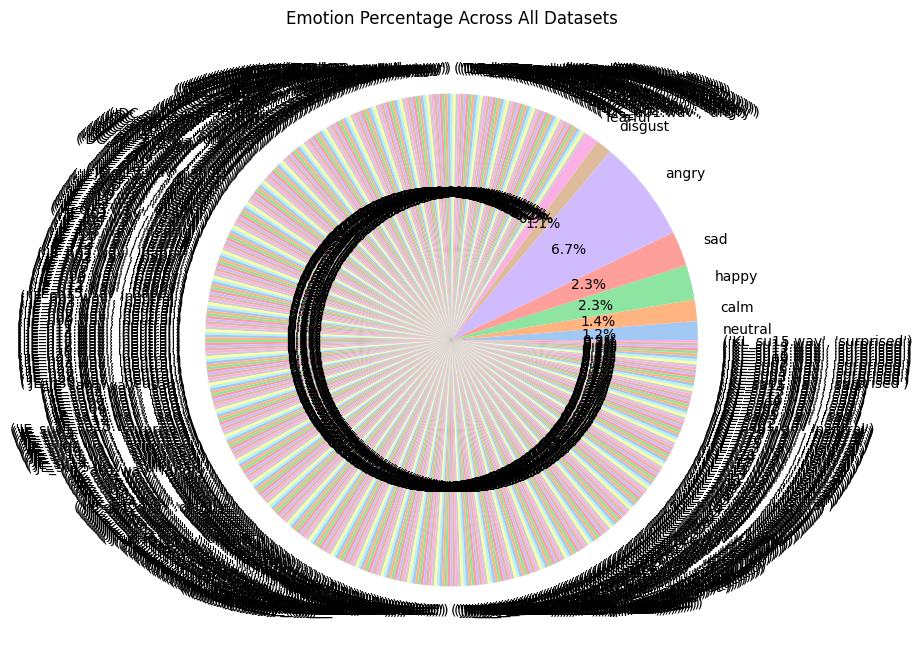

In [17]:
plt.figure(figsize=(8, 8))
plt.pie(emotion_counts.values(), labels=emotion_counts.keys(), autopct='%1.1f%%', colors=sns.color_palette("pastel"))
plt.title("Emotion Percentage Across All Datasets")
plt.show()

#### 2.2.1.4 Histogram - Emotion Distribution

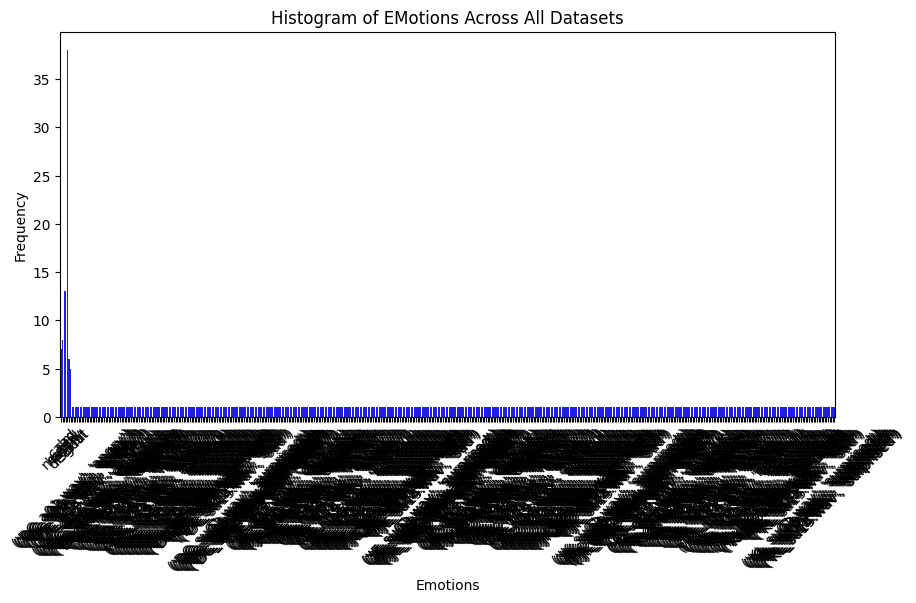

In [18]:
plt.figure(figsize=(10, 5))
sns.countplot(x=all_emotions, color="blue")
plt.xlabel("Emotions")
plt.ylabel("Frequency")
plt.title("Histogram of EMotions Across All Datasets")
plt.xticks(rotation=45)
plt.show()

In [19]:
print(len(all_emotions))


570
